In [2]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

from hfnet.datasets.hpatches import Hpatches
from hfnet.evaluation.visualize import draw_keypoints, draw_matches
from hfnet.evaluation.loaders import sift_loader, export_loader, fast_loader, harris_loader
from hfnet.evaluation.local_descriptors import matching

from utils import plot_images

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
data_config = {'make_pairs': True, 'shuffle': True}
dataset = Hpatches(**data_config)

In [13]:
all_configs = {
    'sift': {
        'predictor': sift_loader,
        'num_features': 500,
        'match_thresh': 0.75,
        'do_ratio_test': True,
    },
    'superpoint': {
        'experiment': 'super_point_pytorch/hpatches',
        'predictor': export_loader,
        'num_features': 500,
        'keypoint_predictor': None,
        'do_nms': True,
        'nms_thresh': 4,
        'remove_borders': 4,
        'match_thresh': 0.7,
        'do_ratio_test': False,
    },
    'mobilenetvlad_L-14': {
        'experiment': 'mobilenetvlad_depth-0.35/hpatches_layer-14',
        'predictor': export_loader,
        'keypoint_predictor': export_loader,
        'keypoint_config': {
            'experiment': 'super_point_pytorch/hpatches',
            'do_nms': True,
            'nms_thresh': 4,
            'remove_borders': 4,
        },
        'num_features': 500,
        'match_thresh': 0.7,
        'do_ratio_test': False,
    },
    'lfnet': {
        'experiment': 'lfnet/hpatches_kpts-500',
        'predictor': export_loader,
        'num_features': 500,
        'remove_borders': 4,
        'match_thresh': 0.7,
        'do_ratio_test': False,
    }
}

In [14]:
configs = {c: all_configs[c] for c in ['sift', 'superpoint', 'mobilenetvlad_L-14', 'lfnet']}
draw_keypoints_instead = True

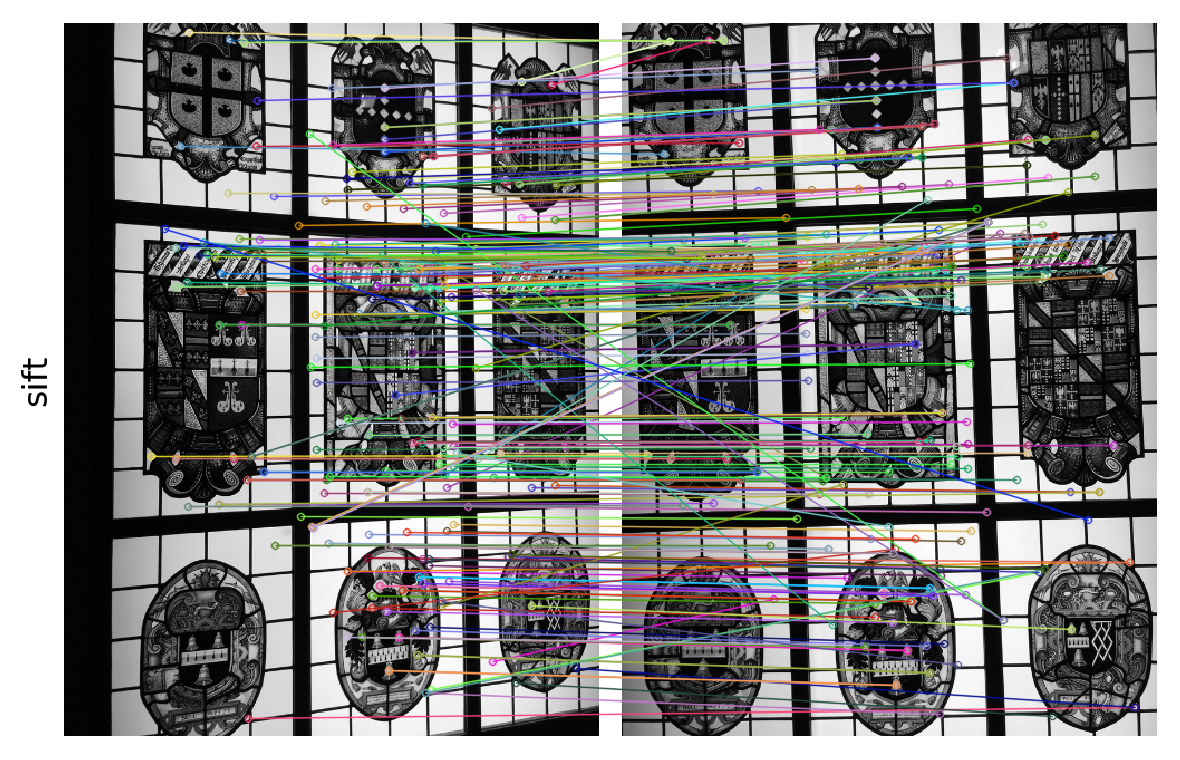

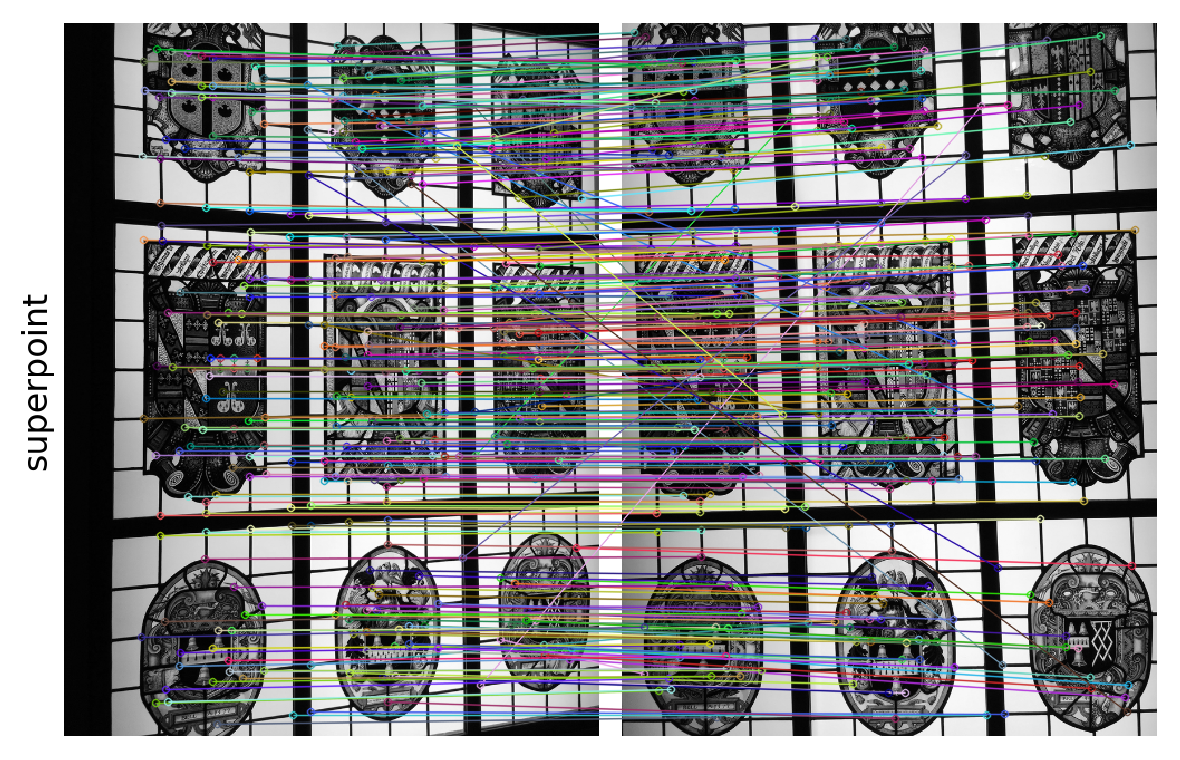

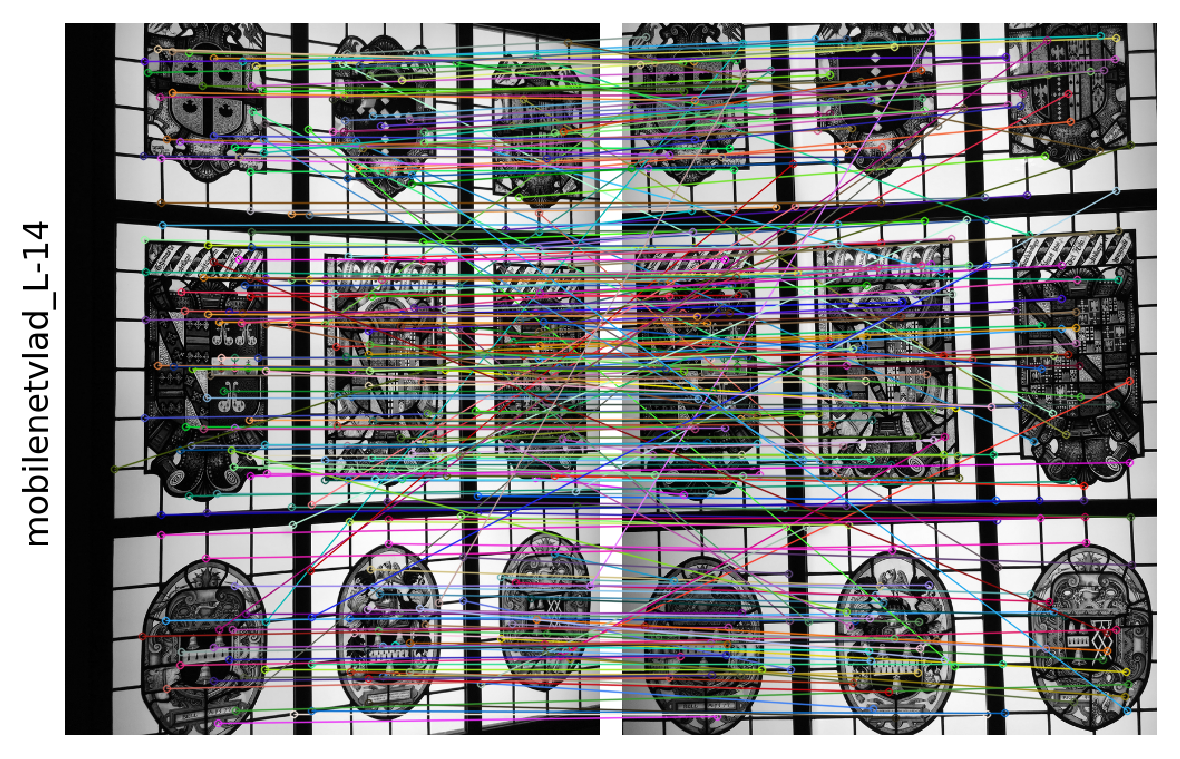

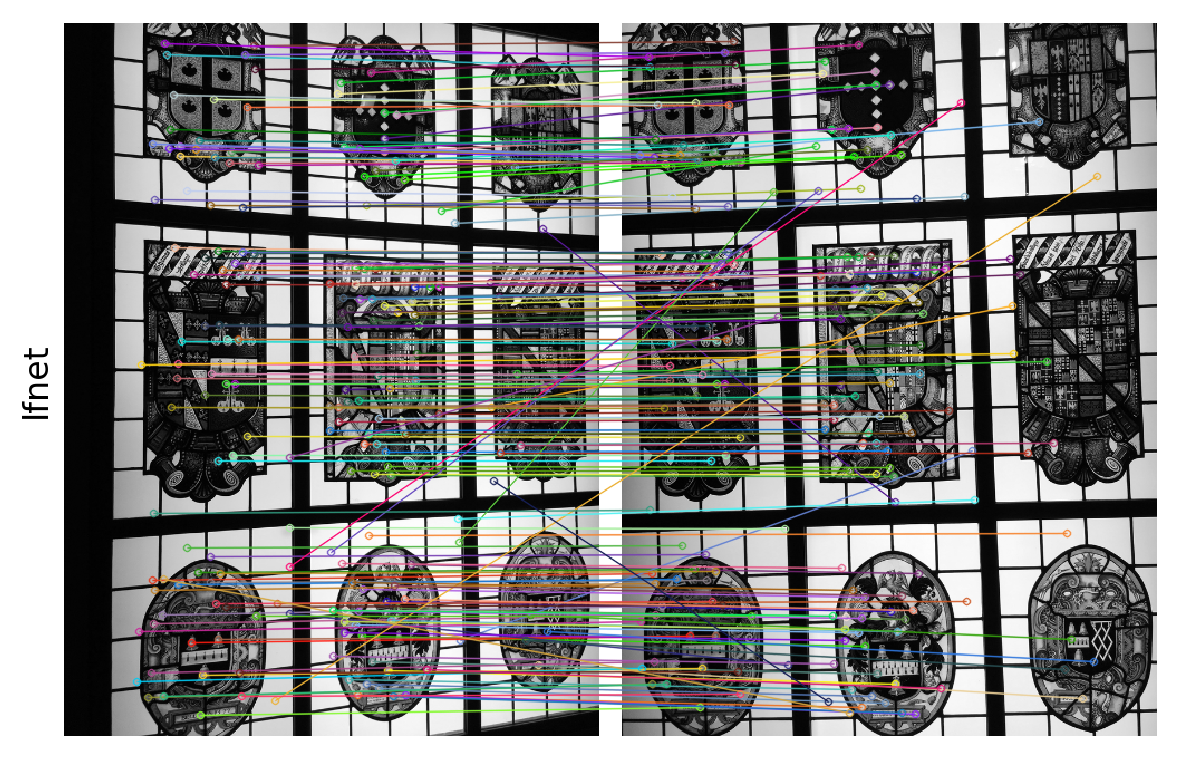

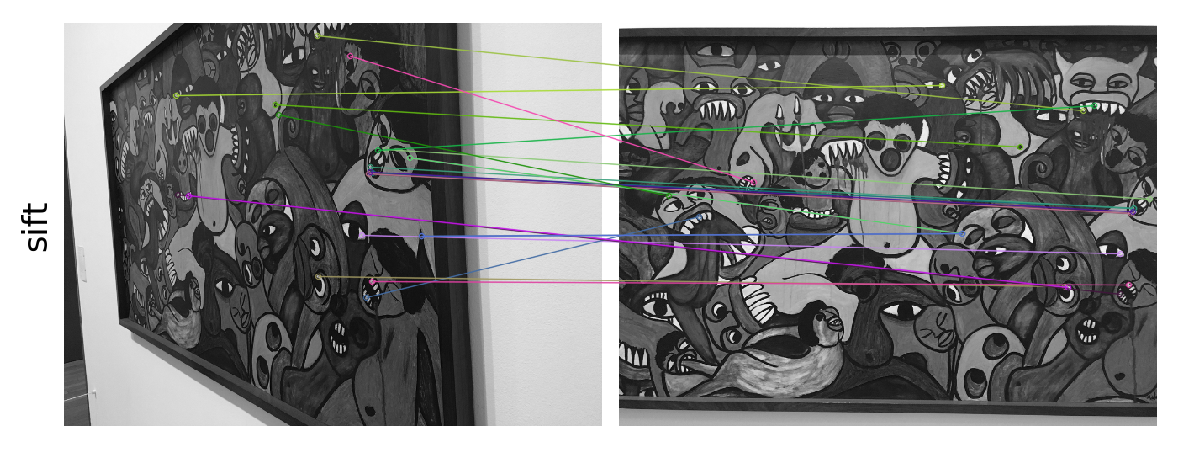

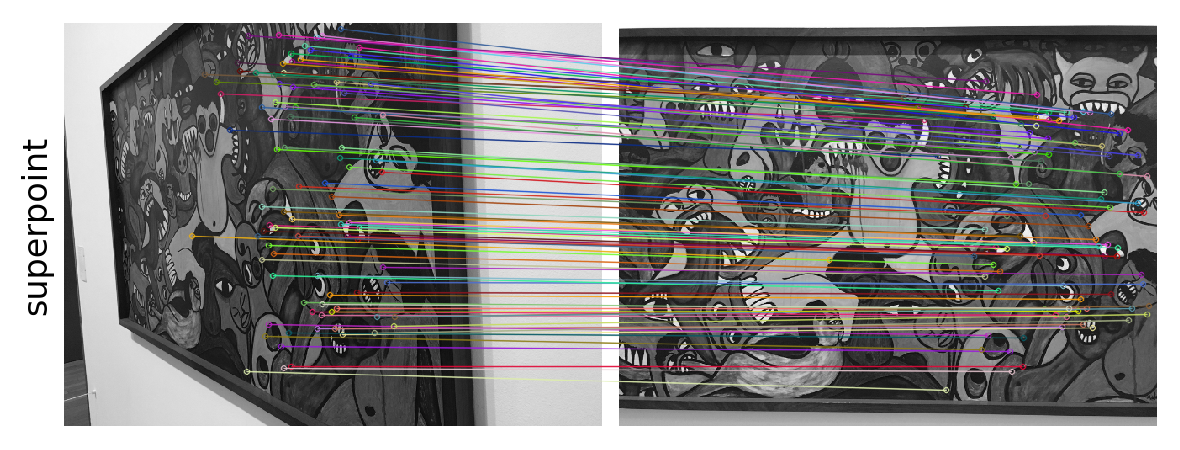

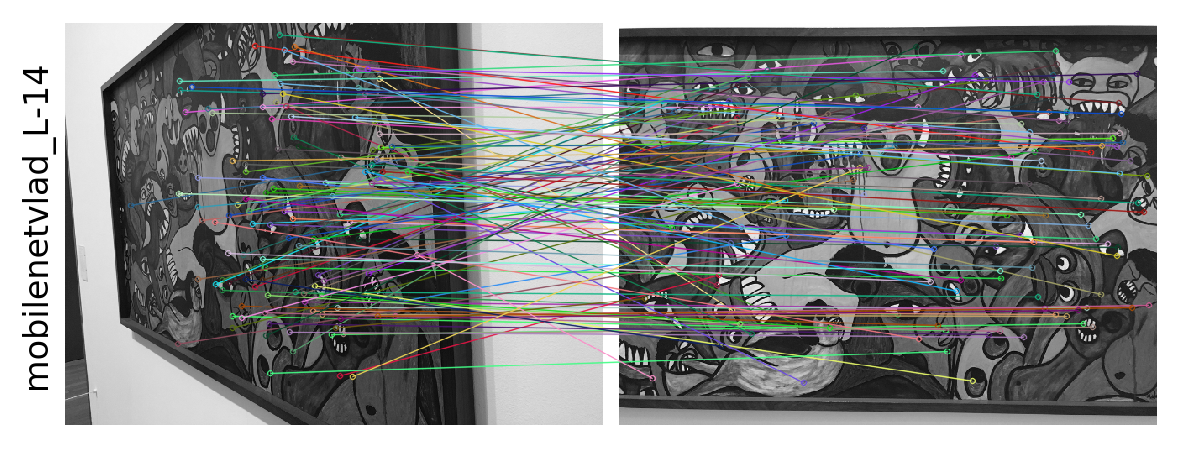

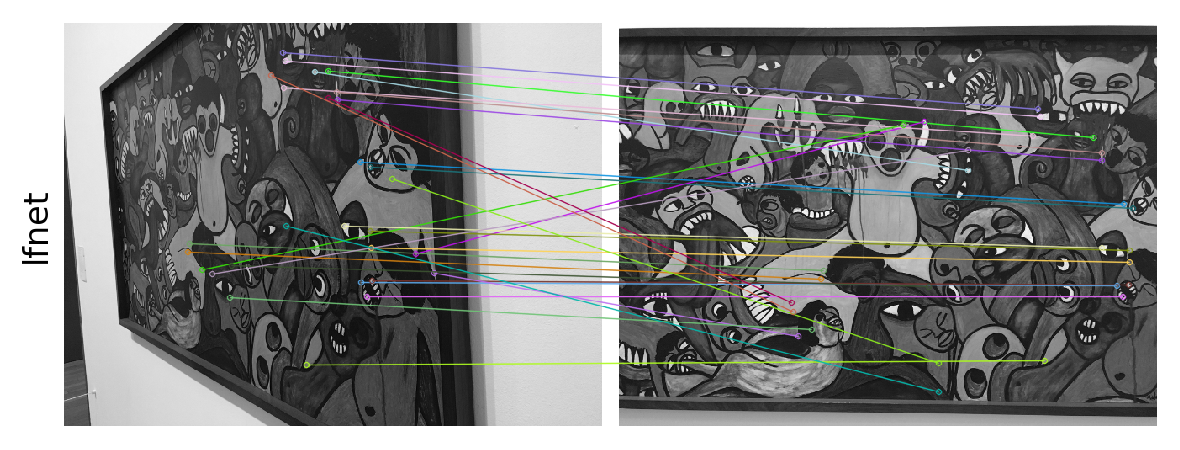

In [15]:
data_iter = dataset.get_test_set()
for _, data in zip(range(2), data_iter):
    for method, config in configs.items():
        pred1 = config['predictor'](data['image'], data['name'], **config)
        pred2 = config['predictor'](data['image2'], data['name2'], **config)

        all_matches, matches_dist = matching(
            pred1['descriptors'], pred2['descriptors'],
            do_ratio_test=config['do_ratio_test'])
        matches = all_matches[matches_dist < config['match_thresh']]
        plot_images(
            [draw_matches(data['image'].astype(np.uint8), pred1['keypoints'],
                          data['image2'].astype(np.uint8), pred2['keypoints'],
                          matches, thickness=1, kp_radius=3)],
            dpi=200, ylabel=method, labelfont=12)